# Image classification using pretrained Resnet-18 and PyTorch

Image classification using STL-10 dataset, which includes 10 classes of images: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.


# Importing Libraries

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Reading class names

In [2]:
from numpy import loadtxt

class_names = []
class_file = open("./STL10/data/stl10_binary/class_names.txt", "r")
line = class_file.readline()
while (line != ''):  # breaks when EOF is reached
    class_names.append(line.strip())
    line = class_file.readline()

print(class_names)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


# Creating Custom Dataset

In [3]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform, class_names):
        def get_images(class_label, class_name):
            images = [x for x in os.listdir(image_dirs[class_label]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.image_dirs = image_dirs
        self.transform = transform
        self.class_names = class_names
        self.class_labels = range(1, len(class_names)+1)
        
        self.images = {}
        for c in self.image_dirs:
            class_name = class_names[c-1]
            self.images[c] = get_images(c, class_name)
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_labels])
    
    def __getitem__(self, index):
        class_label = random.choice(self.class_labels)
        index = index % len(self.images[class_label])
        image_name = self.images[class_label][index]
        image_path = os.path.join(self.image_dirs[class_label], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_labels.index(class_label)
    

# Prepare DataLoader

In [4]:
num_classes = len(class_names) # number of classes
train_dirs = {}
train_path = "./STL10/train"
for i, c in enumerate(class_names):
    train_dirs[i+1] = os.path.join(train_path, str(i+1))

print("Train example directories are: \n", train_dirs)

test_dirs = {}
test_path = "./STL10/test"
for i, c in enumerate(class_names):
    test_dirs[i+1] = os.path.join(test_path, str(i+1))

print("="*50)
print("Test example directories are: \n", test_dirs)

Train example directories are: 
 {1: './STL10/train/1', 2: './STL10/train/2', 3: './STL10/train/3', 4: './STL10/train/4', 5: './STL10/train/5', 6: './STL10/train/6', 7: './STL10/train/7', 8: './STL10/train/8', 9: './STL10/train/9', 10: './STL10/train/10'}
Test example directories are: 
 {1: './STL10/test/1', 2: './STL10/test/2', 3: './STL10/test/3', 4: './STL10/test/4', 5: './STL10/test/5', 6: './STL10/test/6', 7: './STL10/test/7', 8: './STL10/test/8', 9: './STL10/test/9', 10: './STL10/test/10'}


# Image Transformations
Use the mean and std of the training set calculated above to normalize the train and test sets.

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(96, 96)),
    torchvision.transforms.RandomCrop(size=(64, 64)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=(-10, 10)),
    torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.5)),
    torchvision.transforms.ColorJitter(brightness=0.3, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(96, 96)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

In [6]:
# create a DataSet from train images
train_dataset = DataSet(train_dirs, train_transform, class_names)

print("="*50)

# create a DataSet from test images
test_dataset = DataSet(test_dirs, test_transform, class_names)

Found 500 airplane examples
Found 500 bird examples
Found 500 car examples
Found 500 cat examples
Found 500 deer examples
Found 500 dog examples
Found 500 horse examples
Found 500 monkey examples
Found 500 ship examples
Found 500 truck examples
Found 800 airplane examples
Found 800 bird examples
Found 800 car examples
Found 800 cat examples
Found 800 deer examples
Found 800 dog examples
Found 800 horse examples
Found 800 monkey examples
Found 800 ship examples
Found 800 truck examples


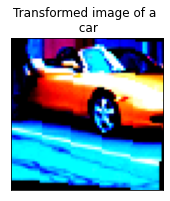

In [7]:
index = 1
image, label = train_dataset[index]
image = image.permute(1,2,0)
image = np.clip(image, 0., 1.)

plt.subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(image)
plt.title('Transformed image of a \n {}'.format(class_names[label]));

In [8]:
batch_size = 10

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Number of created training batches = ', len(dataloader_train))
print('Number of created test batches =', len(dataloader_test))

Number of created training batches =  500
Number of created test batches = 800


# Data Visualization

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(2, 5, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'True label: {class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'Predicted: {class_names[int(preds[i].numpy())]}', color=col)
    
    plt.tight_layout()
    plt.show()

# Let's check the visualization function
Here I use (preds=labels) just to test the show_images(images, labels, preds) function above.

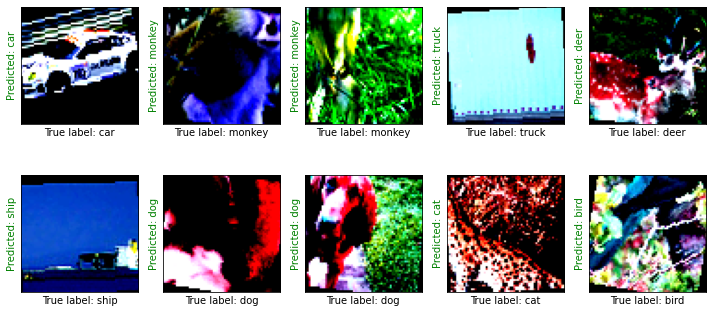

In [10]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)
#print(resnet18)

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 5e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1)

# Function to show the predicted label of a batch

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dataloader_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

## Let's check the model prediction before training the model
It's expected to get most predictions wrong!

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


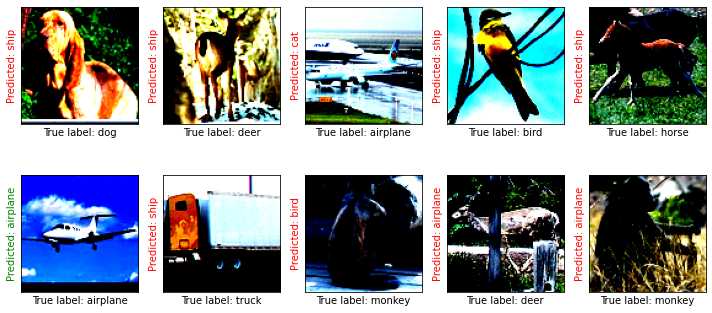

In [14]:
show_preds()

# Train the model

In [15]:
train_loss_array = np.array([])
train_accu_array = np.array([])
valid_loss_array = np.array([])
valid_accu_array = np.array([])
confusion_matrix = np.zeros((num_classes, num_classes))
epoch_number_array = np.array([])

epochs = 20

print('Starting training!')
print('='*20)
    
for e in range(0, epochs):
    print('='*20)
    print(f'Training epoch {e+1}/{epochs}')
    print('='*20)
    epoch_number_array = np.append(epoch_number_array, e+1)
    
    train_accu = 0.
    train_loss = 0.     
    resnet18.train()

    for (images, labels) in tqdm(dataloader_train):  
            
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_accu += sum((preds == labels).numpy())
            
    train_loss /= len(dataloader_train)
    train_accu /= (len(dataloader_train)*batch_size)
    train_loss_array = np.append(train_loss_array, train_loss)
    train_accu_array = np.append(train_accu_array, train_accu)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accu:.4f}')

    val_accu = 0.
    val_loss = 0.
    resnet18.eval()

    for (images, labels) in tqdm(dataloader_test):            
        outputs = resnet18(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()            
        _, preds = torch.max(outputs, 1)
        val_accu += sum((preds == labels).numpy())
        if (e+1 == epochs):
            for p, t in zip(preds, labels):
                 confusion_matrix[p, t] += 1
                    
    val_loss /= len(dataloader_test)
    val_accu /= (len(dataloader_test)*batch_size)
    valid_loss_array = np.append(valid_loss_array, val_loss)
    valid_accu_array = np.append(valid_accu_array, val_accu)
    print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accu:.4f}')
    
    #scheduler.step(val_loss)
    #for param_group in optimizer.param_groups:
    #    print('Current value of the learning rate = {}'.format(param_group['lr']))

Starting training!
Training epoch 1/20


100%|██████████| 500/500 [03:06<00:00,  2.68it/s]


Train loss: 1.4291, Train accuracy: 0.5030


100%|██████████| 800/800 [02:12<00:00,  6.04it/s]


Validation loss: 0.9496, Validation accuracy: 0.7444
Training epoch 2/20


100%|██████████| 500/500 [03:11<00:00,  2.61it/s]


Train loss: 1.0560, Train accuracy: 0.6310


100%|██████████| 800/800 [02:12<00:00,  6.06it/s]


Validation loss: 0.7504, Validation accuracy: 0.7760
Training epoch 3/20


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Train loss: 0.9262, Train accuracy: 0.6808


100%|██████████| 800/800 [02:13<00:00,  5.98it/s]


Validation loss: 0.6389, Validation accuracy: 0.8066
Training epoch 4/20


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Train loss: 0.8576, Train accuracy: 0.7022


100%|██████████| 800/800 [02:11<00:00,  6.10it/s]


Validation loss: 0.6364, Validation accuracy: 0.8073
Training epoch 5/20


100%|██████████| 500/500 [03:07<00:00,  2.66it/s]


Train loss: 0.8186, Train accuracy: 0.7194


100%|██████████| 800/800 [02:15<00:00,  5.91it/s]


Validation loss: 0.5654, Validation accuracy: 0.8303
Training epoch 6/20


100%|██████████| 500/500 [03:08<00:00,  2.66it/s]


Train loss: 0.7587, Train accuracy: 0.7362


100%|██████████| 800/800 [02:12<00:00,  6.03it/s]


Validation loss: 0.5524, Validation accuracy: 0.8211
Training epoch 7/20


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Train loss: 0.7224, Train accuracy: 0.7528


100%|██████████| 800/800 [02:12<00:00,  6.04it/s]


Validation loss: 0.5306, Validation accuracy: 0.8225
Training epoch 8/20


100%|██████████| 500/500 [03:04<00:00,  2.71it/s]


Train loss: 0.6842, Train accuracy: 0.7592


100%|██████████| 800/800 [02:11<00:00,  6.07it/s]


Validation loss: 0.4839, Validation accuracy: 0.8475
Training epoch 9/20


100%|██████████| 500/500 [03:04<00:00,  2.71it/s]


Train loss: 0.6657, Train accuracy: 0.7780


100%|██████████| 800/800 [02:10<00:00,  6.15it/s]


Validation loss: 0.4551, Validation accuracy: 0.8578
Training epoch 10/20


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Train loss: 0.6463, Train accuracy: 0.7760


100%|██████████| 800/800 [02:12<00:00,  6.06it/s]


Validation loss: 0.4818, Validation accuracy: 0.8431
Training epoch 11/20


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Train loss: 0.5854, Train accuracy: 0.7962


100%|██████████| 800/800 [02:12<00:00,  6.06it/s]


Validation loss: 0.4760, Validation accuracy: 0.8410
Training epoch 12/20


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Train loss: 0.5832, Train accuracy: 0.7984


100%|██████████| 800/800 [02:11<00:00,  6.09it/s]


Validation loss: 0.4324, Validation accuracy: 0.8536
Training epoch 13/20


100%|██████████| 500/500 [03:04<00:00,  2.72it/s]


Train loss: 0.5673, Train accuracy: 0.7988


100%|██████████| 800/800 [02:10<00:00,  6.11it/s]


Validation loss: 0.4163, Validation accuracy: 0.8678
Training epoch 14/20


100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


Train loss: 0.5502, Train accuracy: 0.8104


100%|██████████| 800/800 [02:11<00:00,  6.11it/s]


Validation loss: 0.4709, Validation accuracy: 0.8440
Training epoch 15/20


100%|██████████| 500/500 [03:03<00:00,  2.73it/s]


Train loss: 0.5419, Train accuracy: 0.8108


100%|██████████| 800/800 [02:10<00:00,  6.11it/s]


Validation loss: 0.4164, Validation accuracy: 0.8618
Training epoch 16/20


100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


Train loss: 0.4885, Train accuracy: 0.8324


100%|██████████| 800/800 [02:11<00:00,  6.09it/s]


Validation loss: 0.3990, Validation accuracy: 0.8721
Training epoch 17/20


100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


Train loss: 0.4987, Train accuracy: 0.8228


100%|██████████| 800/800 [02:11<00:00,  6.08it/s]


Validation loss: 0.4185, Validation accuracy: 0.8649
Training epoch 18/20


100%|██████████| 500/500 [03:03<00:00,  2.73it/s]


Train loss: 0.4722, Train accuracy: 0.8406


100%|██████████| 800/800 [02:11<00:00,  6.11it/s]


Validation loss: 0.4063, Validation accuracy: 0.8670
Training epoch 19/20


100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


Train loss: 0.4704, Train accuracy: 0.8372


100%|██████████| 800/800 [02:11<00:00,  6.10it/s]


Validation loss: 0.4242, Validation accuracy: 0.8569
Training epoch 20/20


100%|██████████| 500/500 [03:04<00:00,  2.71it/s]


Train loss: 0.4606, Train accuracy: 0.8392


100%|██████████| 800/800 [02:11<00:00,  6.08it/s]

Validation loss: 0.4036, Validation accuracy: 0.8720


## Let's check the model prediction after training the model
It's expected to get most predictions correct!

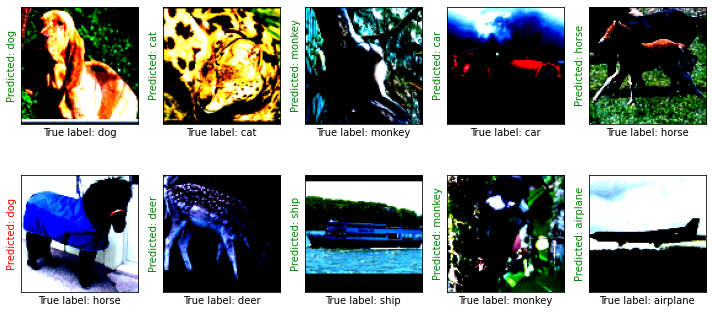

In [16]:
show_preds()

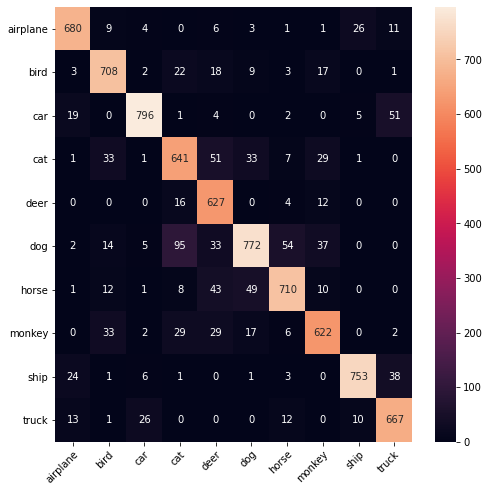

In [17]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.heatmap(confusion_matrix, annot=True, xticklabels=True, yticklabels=True, fmt='g')
ax.set_xticklabels(class_names);
ax.set_yticklabels(class_names);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor");
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
        rotation_mode="anchor");
plt.show()

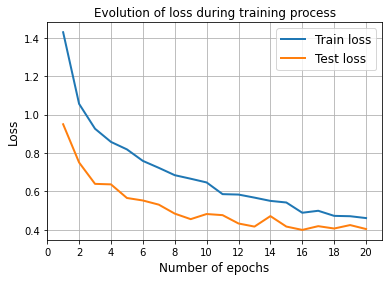

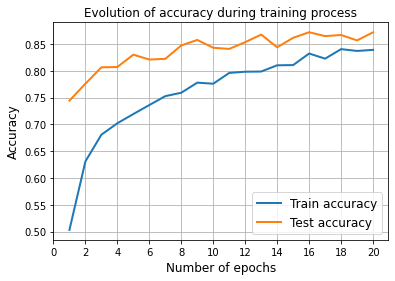

In [18]:
fig, ax = plt.subplots()
plt.xlim([0, epochs+1])
plt.plot(epoch_number_array, train_loss_array, lw=2, label='Train loss')
plt.plot(epoch_number_array, valid_loss_array, lw=2, label='Test loss')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(np.arange(0, epochs+1, 2))
plt.title('Evolution of loss during training process', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.plot(epoch_number_array, train_accu_array, lw=2, label='Train accuracy')
plt.plot(epoch_number_array, valid_accu_array, lw=2, label='Test accuracy')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(0, epochs+1, 2))
plt.title('Evolution of accuracy during training process', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show() 
